In [1]:
import napari


In [2]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import tifffile
import yaml
from torchio.transforms import Resize
from einops import rearrange

import napari

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [25]:
from mushroom.data.multiplex import extract_ome_tiff
from mushroom.data.visium import adata_from_visium, pixels_per_micron
from mushroom.visualization.utils import calculate_target_visualization_shape
from mushroom.visualization.viewer import MushroomViewer
from mushroom.visualization.utils import display_labeled_as_rgb

In [6]:
config_filepath = '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/mushroom_outputs/multiplex/config_local.yaml'
outputs_filepath = '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/mushroom_outputs/multiplex/outputs.pt'


In [7]:
output_data = torch.load(outputs_filepath)
output_data.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [8]:
for k, v in output_data.items():
    print(k, v.shape)

recon_embs torch.Size([4, 1024, 60, 60])
recon_imgs torch.Size([4, 24, 1920, 1920])
true_imgs torch.Size([4, 24, 1920, 1920])
cluster_distances torch.Size([4, 60, 60, 20])
cluster_distance_volume torch.Size([30, 60, 60, 20])
cluster_centroids torch.Size([20, 1024])
cluster_ids torch.Size([4, 60, 60])


In [9]:
config = yaml.safe_load(open(config_filepath))
sections = config['sections']
sections

[{'data': [{'dtype': 'he',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/registered/s0_he.tif'},
   {'dtype': 'visium',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/registered/s0_visium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/registered/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 1},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 11},
 {'data': [{'dtype': 'he',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/registered/s3_he.tif'},
   {'dtype': 'visium',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/examples/HT397B1_v1/registration/r

In [10]:
dtype_to_marker = {
    'visium': 'EPCAM',
}

In [24]:
obj = MushroomViewer(config, output_data, downsample=.5)

In [12]:
img_dicts = obj.get_sections()

960 1920
960 1920
960 1108
960 1108
960 1920
960 1920
960 1920
960 1920


In [13]:
img_dicts[0].keys()

dict_keys(['name', 'img', 'position', 'dtype', 'scale_factor', 'channels'])

In [14]:
for d in img_dicts:
    print(d['name'], d['img'].shape, d['position'], d['dtype'], d['scale_factor'], d['channels'])

he_s0 (1, 1920, 1920) 0 he 0.5 None
he_s3 (1, 1920, 1920) 11 he 0.5 None
visium_s0 (1, 1108, 1108) 0 visium 0.8664259927797834 None
visium_s3 (1, 1108, 1108) 11 visium 0.8664259927797834 None
multiplex_s1 (25, 1920, 1920) 0 multiplex 0.5 ['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
multiplex_s2 (25, 1920, 1920) 6 multiplex 0.5 ['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
multiplex_s4 (27, 1920, 1920) 11 multiplex 0.5 ['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 

In [22]:
obj.volume.shape, obj.cluster_ids.shape

(torch.Size([20, 17, 960, 960]), torch.Size([4, 17, 960]))

In [28]:
import seaborn as sns

In [29]:
def to_uint8(x):
    if isinstance(x, torch.Tensor):
        x = x.numpy()
    x = x.astype(np.float32)
    x -= x.min()
    
    x /= x.max()
    x *= 255.
    x = x.astype(np.uint8)
    return x

def display_napari(img_dicts, volume):
    viewer = napari.Viewer(ndisplay=3)
        
    
    volume = volume.max() - volume
    volume = to_uint8(volume)
    for cluster in range(volume.shape[0]):
#         x = rearrange(volume[cluster], 'z y x -> ')
        x = volume[cluster]
        viewer.add_image(
            x,
            depiction='volume',
            rendering='iso',
            iso_threshold=200.,
            name=f'cluster {cluster}',
            visible=False
        )
    
    cmap = sns.color_palette('tab20') + sns.color_palette('tab20b')
    for labeled in obj.cluster_ids:   
        img = display_labeled_as_rgb(labeled, cmap=cmap)
        sf =  volume.shape[-2] / labeled.shape[-2]
        viewer.add_image(
            img,
            name='max cluster',
            scale=[sf, sf]
        )
    
    for d in img_dicts:
        if d['dtype'] == 'multiplex':
            x = to_uint8(d['img'])
            name = d['name']
            for channel, img in zip(d['channels'], x):
                img = np.expand_dims(img, 0)
                viewer.add_image(
                    img,
                    name=f'{name}_{channel}',
                    visible=False,
                    opacity=.3,
                    translate=[d['position'], 0, 0],
                    scale=[1, d['scale_factor'], d['scale_factor']]
                )
        if d['dtype'] == 'visium':
            x = to_uint8(d['img'])
            name = d['name']
            viewer.add_image(
                x,
                name=name,
                visible=False,
                opacity=.3,
                translate=[d['position'], 0, 0],
                scale=[1, d['scale_factor'], d['scale_factor']]
            )
        if d['dtype'] == 'he':
            x = to_uint8(d['img'])
            name = d['name']
            viewer.add_image(
                x,
                name=name,
                visible=False,
                opacity=.3,
                translate=[d['position'], 0, 0],
                scale=[1, d['scale_factor'], d['scale_factor']]
            )

    
    

In [30]:
display_napari(img_dicts, obj.volume)
napari.run()

In [79]:
# x = rearrange(obj.volume, 'z y x c -> z c y x')
x = obj.volume.clone()
x = x.numpy()
x /= x.max()
x *= 255.
x = x.astype(np.uint8)
x = x.max() - x

x = rearrange(x, 'z y x c -> z y x c')
x.shape

(17, 960, 960, 20)

In [53]:
he = obj.dtype_to_planes['he'].get_image('s0')
he = rearrange(he, 'c h w -> h w c')
he_scale = x.shape[1] / he.shape[1]
he.shape

(1920, 1920, 3)

(1108, 1108, 3)

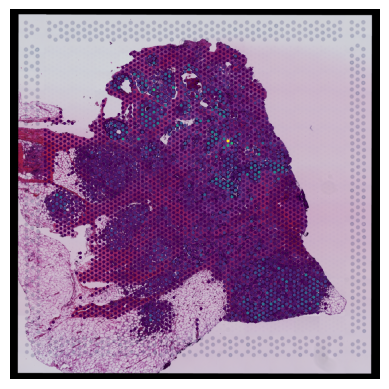

In [54]:
visium = obj.dtype_to_planes['visium'].get_image('s0', marker='EPCAM')
visium = rearrange(visium, 'c h w -> h w c')
visium_scale = x.shape[1] / visium.shape[1]
visium.shape

In [90]:
gray = he.mean(-1)
gray /= gray.max()
gray *= 255.
gray = gray.astype(np.uint8)
gray = np.expand_dims(gray, 0)
gray.shape

(1, 1920, 1920)

In [92]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(x[..., 19], depiction='volume', iso_threshold=190.)

plane_parameters = {
    'position': (10,0,0),
#     'normal': (0, 0, 1),
#     'thickness': 10,
}


layer = viewer.add_image(
    gray, depiction='plane', rgb=False, scale=[1, he_scale, he_scale], translate=[50, 0, 0]
)
# layer = viewer.add_image(
#     he, depiction='plane', rgb='True', scale=[he_scale, he_scale], translate=[50, 0]
# )

# layer = viewer.add_image(
#     visium, depiction='plane', rgb='True', scale=[visium_scale, visium_scale]
# )


if __name__ == '__main__':
    napari.run()

In [85]:
layer.

2

In [25]:


# # load multichannel image in one line
# viewer = napari.view_image(x, channel_axis=1)

# load multichannel image in one line, with additional options
viewer = napari.view_image(
        x,
        channel_axis=1,
        name=[f'cluster_{i}' for i in range(x.shape[1])],
#         colormap=["green", "magenta"],
#         contrast_limits=[[1000, 20000], [1000, 50000]],
        )
if __name__ == '__main__':
    napari.run()

In [23]:
import napari

cells = skimage.data.cells3d() #ZCYX image data

# load multichannel image in one line
viewer = napari.view_image(cells, channel_axis=1)

# load multichannel image in one line, with additional options
viewer = napari.view_image(
        cells,
        channel_axis=1,
        name=["membrane", "nuclei"],
        colormap=["green", "magenta"],
        contrast_limits=[[1000, 20000], [1000, 50000]],
        )

if __name__ == '__main__':
    napari.run()

In [36]:
import numpy as np
from skimage import data

import napari
from napari.utils.translations import trans

viewer = napari.Viewer(ndisplay=3)

# add a 3D image
blobs = data.binary_blobs(
    length=64, volume_fraction=0.1, n_dim=3
).astype(np.float32)
image_layer = viewer.add_image(
    blobs, rendering='mip', name='volume', blending='additive', opacity=0.25
)

# add the same 3D image and render as plane
# plane should be in 'additive' blending mode or depth looks all wrong
plane_parameters = {
    'position': (32, 32, 32),
    'normal': (0, 1, 0),
    'thickness': 10,
}

plane_layer = viewer.add_image(
    blobs,
    rendering='average',
    name='plane',
    depiction='plane',
    blending='additive',
    opacity=0.5,
    plane=plane_parameters
)
viewer.axes.visible = True
viewer.camera.angles = (45, 45, 45)
viewer.camera.zoom = 5
viewer.text_overlay.text = trans._(
    """
shift + click and drag to move the plane
press 'x', 'y' or 'z' to orient the plane along that axis around the cursor
press 'o' to orient the plane normal along the camera view direction
press and hold 'o' then click and drag to make the plane normal follow the camera
"""
)
viewer.text_overlay.visible = True
if __name__ == '__main__':
    napari.run()

In [14]:
import numpy as np
import skimage
from skimage.transform import pyramid_gaussian

import napari

# create multiscale from astronaut image
base = np.tile(skimage.data.astronaut(), (8, 8, 1))
multiscale = list(
    pyramid_gaussian(base, downscale=2, max_layer=4, channel_axis=-1)
)
print('multiscale level shapes: ', [p.shape[:2] for p in multiscale])

# add image multiscale
viewer = napari.view_image(multiscale, multiscale=True, )

if __name__ == '__main__':
    napari.run()

multiscale level shapes:  [(4096, 4096), (2048, 2048), (1024, 1024), (512, 512), (256, 256)]


In [19]:
import numpy as np
from skimage import data

import napari

blobs = data.binary_blobs(
            length=128, blob_size_fraction=0.05, n_dim=3, volume_fraction=0.05
        )

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(blobs.astype(float))

# sample vector coord-like data
path = np.array([np.array([[0, 0, 0], [0, 10, 10], [0, 5, 15], [20, 5, 15],
    [56, 70, 21], [127, 127, 127]]),
    np.array([[0, 0, 0], [0, 10, 10], [0, 5, 15], [0, 5, 15],
        [0, 70, 21], [0, 127, 127]])])

print('Path', path.shape)
layer = viewer.add_shapes(
    path, shape_type='path', edge_width=4, edge_color=['red', 'blue']
)

if __name__ == '__main__':
    napari.run()

Path (2, 6, 3)


In [ ]:
viewer.